In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! kaggle datasets download tourist55/alzheimers-dataset-4-class-of-images

 94% 32.0M/34.1M [00:01<00:00, 30.7MB/s]
100% 34.1M/34.1M [00:02<00:00, 17.4MB/s]


In [3]:
!unzip alzheimers-dataset-4-class-of-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/m

In [4]:

import os
import shutil
 
sourceTrain = ['/content/Alzheimer_s Dataset/train/ModerateDemented', '/content/Alzheimer_s Dataset/train/MildDemented']
destinationTrain = '/content/Alzheimer_s Dataset/train/VeryMildDemented'

sourceTest = ['/content/Alzheimer_s Dataset/test/ModerateDemented', '/content/Alzheimer_s Dataset/test/MildDemented']
destinationTest = '/content/Alzheimer_s Dataset/test/VeryMildDemented'


for source in sourceTrain:

  allfiles = os.listdir(source)

  for f in allfiles:
    src_path = os.path.join(source, f)
    dst_path = os.path.join(destinationTrain, f)
    shutil.move(src_path, dst_path)
  
 

for source in sourceTest:

  allfiles = os.listdir(source)

  for f in allfiles:
    src_path = os.path.join(source, f)
    dst_path = os.path.join(destinationTest, f)
    shutil.move(src_path, dst_path)

import os

old_name_test = r"/content/Alzheimer_s Dataset/test/VeryMildDemented"
new_name_test = r"/content/Alzheimer_s Dataset/test/Demented"
old_name_train = r"/content/Alzheimer_s Dataset/train/VeryMildDemented"
new_name_train = r"/content/Alzheimer_s Dataset/train/Demented"
os.rename(old_name_train, new_name_train)
os.rename(old_name_test, new_name_test)

%rmdir '/content/Alzheimer_s Dataset/test/MildDemented'
%rmdir '/content/Alzheimer_s Dataset/test/ModerateDemented'
%rmdir '/content/Alzheimer_s Dataset/train/MildDemented'
%rmdir '/content/Alzheimer_s Dataset/train/ModerateDemented'

In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
%matplotlib inline

In [6]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
IMAGE_SIZE = [224, 224]
EPOCHS = 100
batch_size = 64

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/Alzheimer_s Dataset/train',
    validation_split = 0.2,
    subset = "training",
    seed = 1337,
    image_size = IMAGE_SIZE,
    batch_size = 32
)

vals_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/Alzheimer_s Dataset/train',
    validation_split = 0.2,
    subset = "validation",
    seed = 1337,
    image_size = IMAGE_SIZE,
    batch_size = 32,
)

Found 5121 files belonging to 2 classes.
Using 4097 files for training.
Found 5121 files belonging to 2 classes.
Using 1024 files for validation.


In [9]:

classes = ['Dementia', 'NonDementia']
train_ds.class_names = classes
vals_ds.class_names = classes
NUM_CLASSES = len(classes)


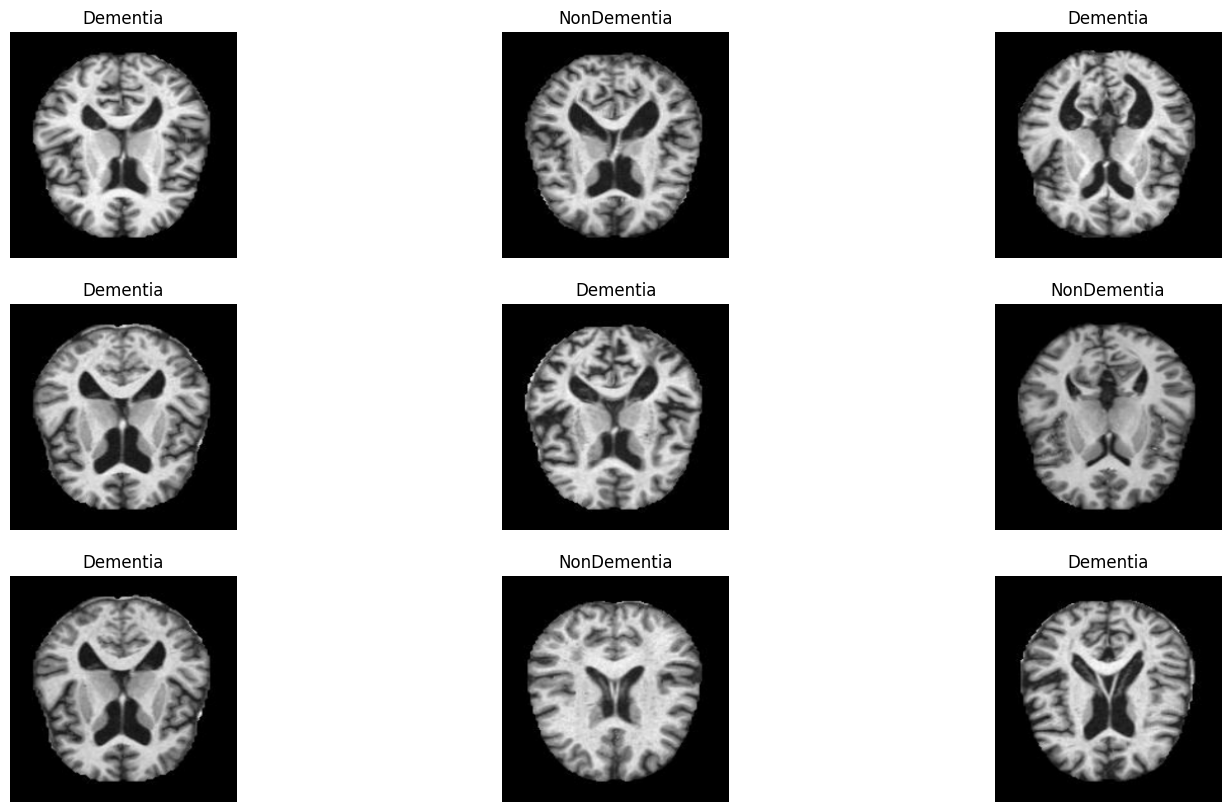

In [10]:
plt.figure(figsize = (18, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis('off')

In [11]:
train_ds.map(lambda x, y: (tf.cast(x, tf.int16), y))
vals_ds.map(lambda x, y: (tf.cast(x, tf.int16), y))

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.int16, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:
def one_hot_label(image, label):
  label = tf.one_hot(label, NUM_CLASSES)
  return image, label

train_ds = train_ds.map(one_hot_label)
vals_ds = vals_ds.map(one_hot_label)

In [13]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
vals_ds = vals_ds.map(lambda x, y: (normalization_layer(x), y))

In [14]:

def conv_blocks(filters):
  block = tf.keras.Sequential([
      tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
      tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D()
  ])
  return block

def dense_block(units, dropout_rate):
  block = tf.keras.Sequential([
      tf.keras.layers.Dense(units, activation = 'relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(dropout_rate)
  ])
  return block


In [15]:
def build_model():
  model = tf.keras.Sequential([
      tf.keras.Input(shape = (*IMAGE_SIZE, 3)),
      tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
      tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
      tf.keras.layers.MaxPool2D(),
      conv_blocks(32),
      conv_blocks(64),
      conv_blocks(128),
      tf.keras.layers.Dropout(0.2),
      conv_blocks(256),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Flatten(),
      dense_block(512, 0.7),
      dense_block(128, 0.5),
      dense_block(64, 0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation = 'sigmoid')
  ])
  return model

In [16]:

model = build_model()
METRICS = ['accuracy',tf.keras.metrics.AUC(name = 'auc')]
model.compile(
    optimizer = 'adam',
    loss = tf.losses.CategoricalCrossentropy(),
    metrics = METRICS
)

In [17]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 56, 56, 32)        2160      
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 64)        7392      
                                                                 
 sequential_2 (Sequential)   (None, 14, 14, 128)       27072     
                                                      

In [18]:
def exponential_decay(lr0, s):
  def exponential_decay_fn(epoch):
    return lr0*0.1**(epoch/s)
  return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model1.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)

In [19]:
with tf.device('/device:GPU:0'):
  history = model.fit(train_ds,
                      validation_data = vals_ds,
                      callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler],
                      epochs = EPOCHS
                    )

Epoch 1/100
129/129 [==============================] - 43s 129ms/step - loss: 0.7034 - accuracy: 0.6175 - auc: 0.6549 - val_loss: 1.1149 - val_accuracy: 0.5010 - val_auc: 0.5874 - lr: 0.0100
Epoch 2/100
129/129 [==============================] - 15s 116ms/step - loss: 0.6333 - accuracy: 0.6563 - auc: 0.7007 - val_loss: 33.8595 - val_accuracy: 0.4990 - val_auc: 0.4990 - lr: 0.0089
Epoch 3/100
129/129 [==============================] - 15s 112ms/step - loss: 0.6264 - accuracy: 0.6522 - auc: 0.7039 - val_loss: 8.5138 - val_accuracy: 0.5039 - val_auc: 0.5079 - lr: 0.0079
Epoch 4/100
129/129 [==============================] - 15s 114ms/step - loss: 0.6058 - accuracy: 0.6732 - auc: 0.7324 - val_loss: 9.0909 - val_accuracy: 0.5039 - val_auc: 0.5030 - lr: 0.0071
Epoch 5/100
129/129 [==============================] - 16s 121ms/step - loss: 0.5892 - accuracy: 0.6900 - auc: 0.7529 - val_loss: 11.7344 - val_accuracy: 0.5000 - val_auc: 0.5049 - lr: 0.0063
Epoch 6/100
129/129 [======================

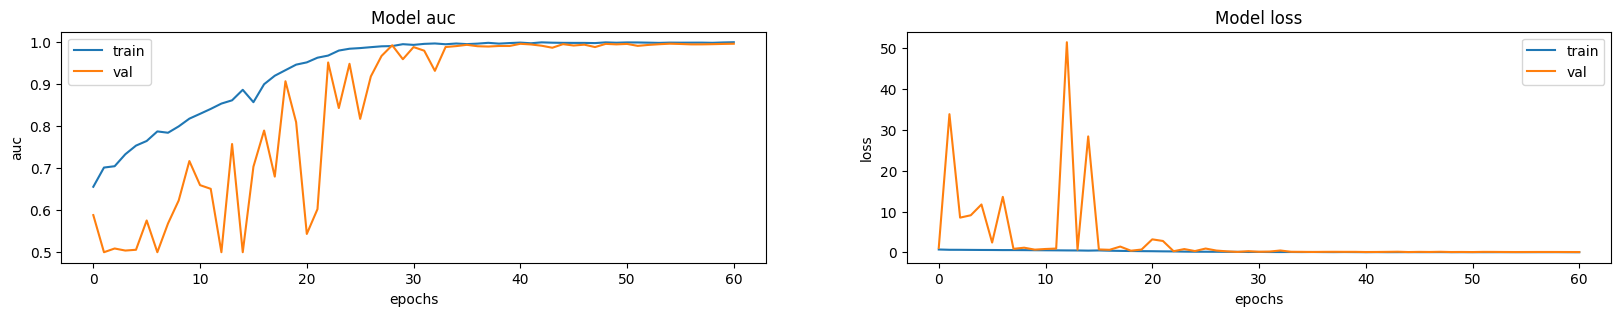

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (20, 3))
ax = ax.ravel()
for i, met in enumerate(['auc', 'loss']):
  ax[i].plot(history.history[met])
  ax[i].plot(history.history['val_' + met])
  ax[i].set_title('Model {}'.format(met))
  ax[i].set_xlabel('epochs')
  ax[i].set_ylabel(met)
  ax[i].legend(['train', 'val'])

In [21]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory('/content/Alzheimer_s Dataset/test',
                                                              image_size = IMAGE_SIZE,
                                                              batch_size = 32,
                                                              )
test_ds.map(lambda x, y: (tf.cast(x, tf.int16), y))
test_ds =  test_ds.map(one_hot_label)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
_ = model.evaluate(test_ds)

Found 1098 files belonging to 2 classes.
35/35 [==============================] - 2s 38ms/step - loss: 0.8167 - accuracy: 0.7714 - auc: 0.8478
